## kaggleのデータセットを用いてモデルを構築する

#### 目的：クラウドファンディングが成功するかを予測するモデルを構築する
#### Kickstarter Projects URL:https://www.kaggle.com/kemical/kickstarter-projects
- 利用するデータ「ks-projects-201801.csv」（データ数：378,661行15列）

### 【手順】
#### 1.データ読込
#### 2.データ前処理
- 事前に予測できない項目は、除外する
- 目的変数と説明変数の関係を確認するためのグラフを作成する
- 目的変数を説明するのに有効そうな説明変数を見つける
- 質的変数が扱えない場合は、ダミー変数に置き換える

#### 3.モデル生成
- ロジスティック回帰モデルを利用する

#### 4.モデル評価
- 混同行列を作成し、Accuracy、Recall、Precisionを求める


| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | ID| 識別ID | - | 不要と思われる為除外 |
|  2 | name |名称 | 欠損あり | 不要と思われる為除外 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日時 | - | ○※期間算出 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使うため除外 |
|  8 | launched |開始日時 | - | ○※期間算出,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | 予測できないため除外 |
| 10 | state |プロジェクトの状態 | - | ○※成功と失敗のみ抽出 |
| 11 | backers |支援者数 | - | 予測できないため除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | 予測できないため除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | 予測できないため除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |


▼ 相関係数をヒートマップにして可視化


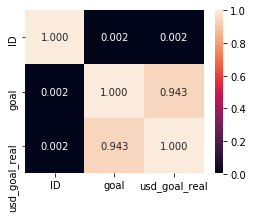

→goalを除外して、usd_goal_realを利用する。

▼ 目的変数 stateの種類（%）


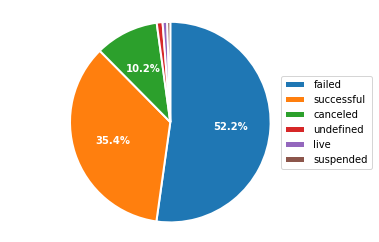

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。

▼ stateが成功または失敗のデータを抽出
failed        197719
successful    133956
Name: state, dtype: int64

▼ 目的変数への影響度を確認する為、成功率の平均値を抽出
0.4038772895153388


In [310]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
from collections import Counter

# ============================================================================
# 関数：各データの件数を確認するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート指定
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print("\n▼" + str(col_name) + "別の成功数と失敗数（降順）")
        ax = sns.countplot(df[col_name],hue=df['state'],order = df[col_name].value_counts().index)
    else:
        print("\n▼" + str(col_name) + "別の成功数と失敗数 ")
        ax = sns.countplot(df[col_name],hue=df['state'])
        
    ax.set_title("Count by " + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel("Count")
    plt.legend()
    plt.show()

# ============================================================================
# 関数：各データの成功率を確認するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無
# ============================================================================
def show_successrate_barplot(col_name, w, h, sort_flg=False):
    successrate = pd.DataFrame(df['state'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('state', ascending=False)
        print("\n▼ " + str(col_name) + "別の成功率（降順）")
    else:
        print("\n▼ " + str(col_name) + "別の成功率")
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="state", data=successrate)
    ax.set_title("Success rate by " + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel("Ratio")
    plt.show()

# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

#print("\n▼ 欠損データ確認")
#print(df.isnull().sum()[df.isnull().sum()>0])

#print("\n▼ 先頭5行")
#print(df.head(5))

# ****************************************************************************
# ◆ 2.前処理
# ****************************************************************************

# ------------------------------------------------
# 2-1.項目の選定
# ------------------------------------------------

# 事前に予測できない項目を削除
df = df.drop(['backers'], axis=1)          # 集客数は事前に予測できない為、除外
df = df.drop(['pledged'], axis=1)          # 集まった資金は事前に予測できない為、除外
df = df.drop(['usd pledged'], axis=1)      # 欠損があり、集まった資金は事前に予測できない為、除外
df = df.drop(['usd_pledged_real'], axis=1) # 集まった資金は事前に予測できない為、除外

# 相関係数をヒートマップにして可視化
print("\n▼ 相関係数をヒートマップにして可視化")
plt.figure(figsize=(4,3))
sns.heatmap(df.corr(), annot=True, fmt="1.3f")
plt.show()
print("→goalを除外して、usd_goal_realを利用する。")

df = df.drop(['ID'], axis=1)               # モデル作成に不要と考え除外
df = df.drop(['name'], axis=1)             # 欠損があり、モデル作成に不要と考え除外
df = df.drop(['goal'], axis=1)             # usd_goal_realとほぼ等しい為、除外

# ------------------------------------------------
# 2-2.目的変数（state）の前処理
# ------------------------------------------------
print("\n▼ 目的変数 stateの種類（%）")
per_state = round(df["state"].value_counts() / len(df["state"]) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':"white"},
        textprops={'color': "white", 'weight': "bold"},
        counterclock=False,
        startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print("→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。")

# stateが成功または失敗のデータを抽出
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

print("\n▼ stateが成功または失敗のデータを抽出")
print(df["state"].value_counts())

# 変換（成功=1，失敗=0）
df['state'] = df['state'].map({'failed': 0,'successful': 1})

# 成功率の平均
print('\n▼ 目的変数への影響度を確認する為、成功率の平均値を抽出')
print(df['state'].mean())



▼period別の成功数と失敗数 


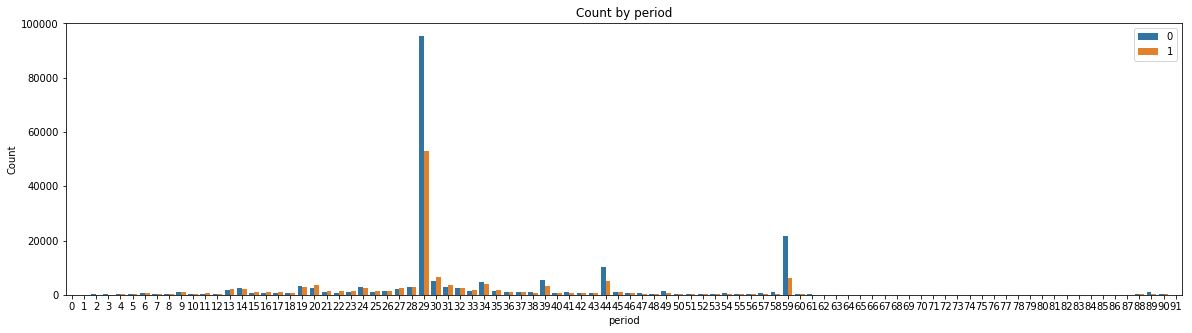


▼ period別の成功率


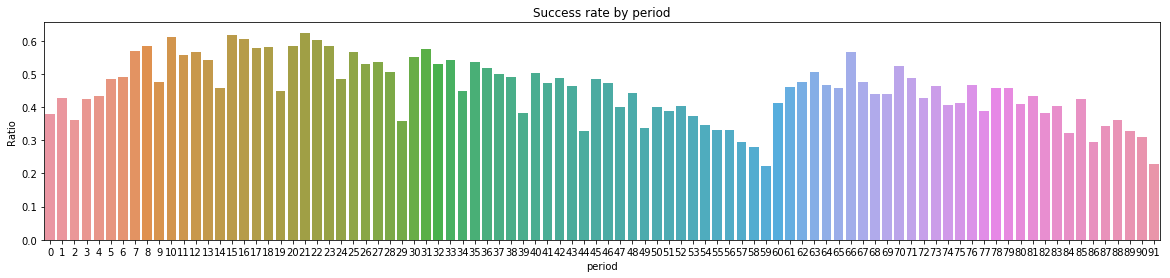

→連続している日数でも、月の節目等で凸凹しているので、ダミー変換することを考える。


In [311]:
# ------------------------------------------------
# 2-3.期間(日数)の算出
# ------------------------------------------------
df['period'] = (df['deadline'] - df['launched']).dt.days

# 日数の分布を確認
show_state_count_plot("period",20,5)
show_successrate_barplot("period",20,4,False)

print("→連続している日数でも、月の節目等で凸凹しているので、ダミー変換することを考える。")


▼ 目標金額(usd_goal_real)の分布 


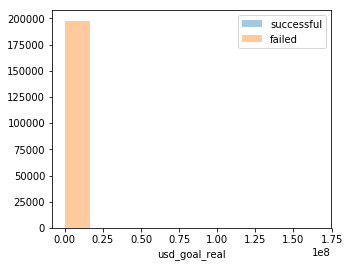

※目標金額の歪度が大きい為、対数変換して分布を修正
83.10938853908664

▼ 対数変換した目標金額(usd_goal_real)の分布 


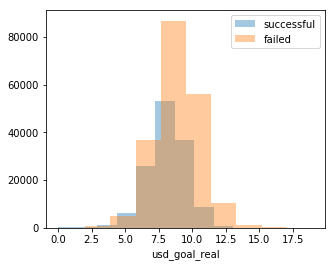

→全体的に目標金額が高くなると失敗しやすくなりそうといえる。


In [312]:
# ------------------------------------------------
# 2-4.目標金額の分布
# ------------------------------------------------
# 目標金額の分布
print("\n▼ 目標金額(usd_goal_real)の分布 ")
plt.figure(figsize=(5,4))
sns.distplot(df[df['state']==1]['usd_goal_real'],kde=False,rug=False,bins=10,label='successful')
sns.distplot(df[df['state']==0]['usd_goal_real'],kde=False,rug=False,bins=10,label='failed')
plt.legend()
plt.show()

print("※目標金額の歪度が大きい為、対数変換して分布を修正")
print(df['usd_goal_real'].skew())

print("\n▼ 対数変換した目標金額(usd_goal_real)の分布 ")
plt.figure(figsize=(5,4))
sns.distplot(np.log1p(df[df['state']==1]['usd_goal_real']),kde=False,rug=False,bins=10,label='successful')
sns.distplot(np.log1p(df[df['state']==0]['usd_goal_real']),kde=False,rug=False,bins=10,label='failed')
plt.legend()
plt.show()

print("→全体的に目標金額が高くなると失敗しやすくなりそうといえる。")


▼launched_Month別の成功数と失敗数 


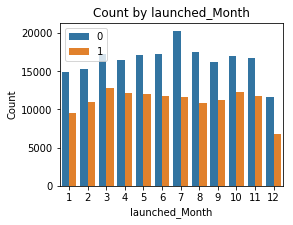


▼ launched_Month別の成功率


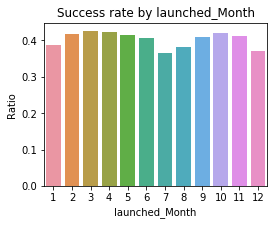

→春と秋あたりに開始すると成功率が高まる。師走は避けたほうが良い。

▼launched_Day別の成功数と失敗数 


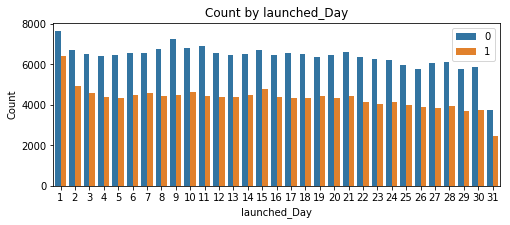


▼ launched_Day別の成功率


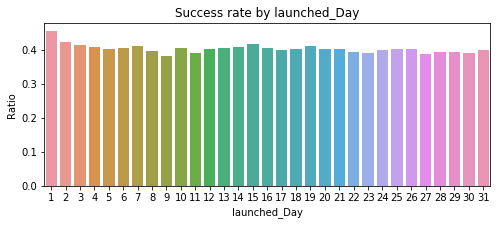

→月の上旬（特に1日開始）の成功率が高い。

▼launched_Hour別の成功数と失敗数 


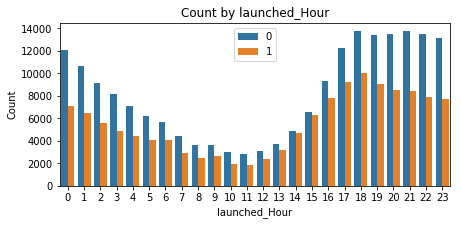


▼ launched_Hour別の成功率


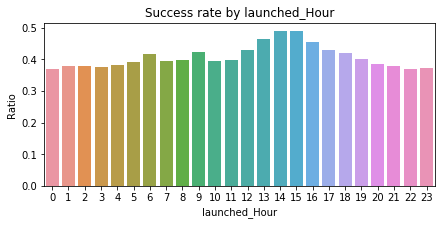

→午後2,3時あたりに開始すると成功率が高まるようだ。


In [313]:
# ------------------------------------------------
# 2-5.開始時期（月、日、時間）の影響度を確認
# ------------------------------------------------
df['launched_Month'] = df['launched'].dt.month
df['launched_Day'] = df['launched'].dt.day
df['launched_Hour'] = df['launched'].dt.hour

show_state_count_plot("launched_Month",4,3)
show_successrate_barplot("launched_Month",4,3)
print("→春と秋あたりに開始すると成功率が高まる。師走は避けたほうが良い。")

show_state_count_plot("launched_Day",8,3)
show_successrate_barplot("launched_Day",8,3)
print("→月の上旬（特に1日開始）の成功率が高い。")

show_state_count_plot("launched_Hour",7,3)
show_successrate_barplot("launched_Hour",7,3)
print("→午後2,3時あたりに開始すると成功率が高まるようだ。")



▼main_category別の成功数と失敗数（降順）


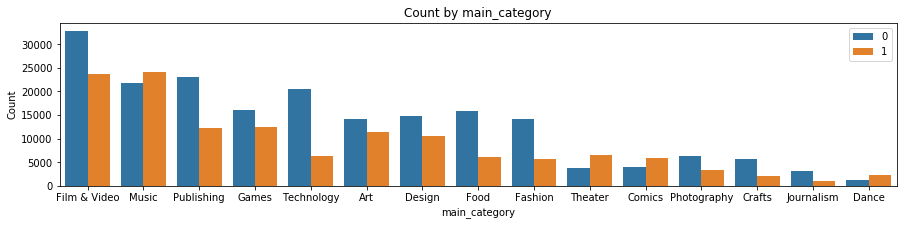


▼ main_category別の成功率（降順）


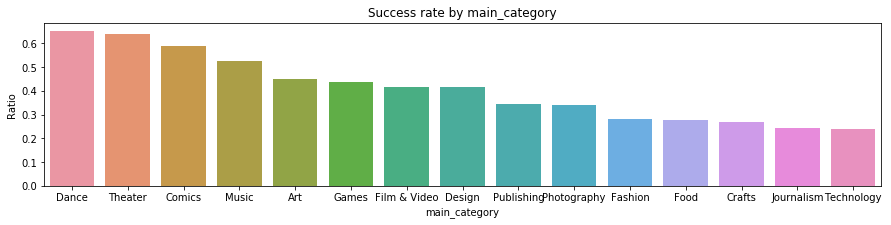


▼category別の成功数と失敗数（降順）


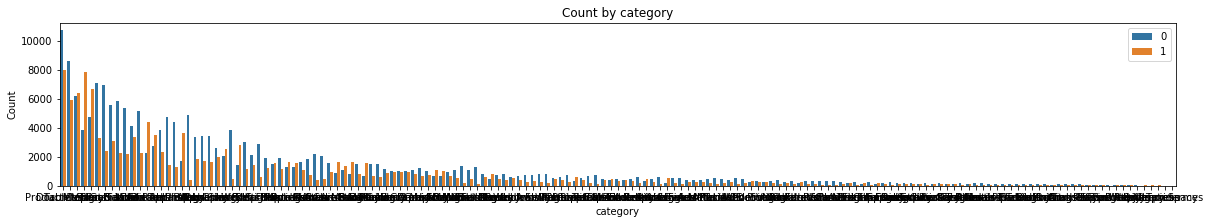


▼ category別の成功率（降順）


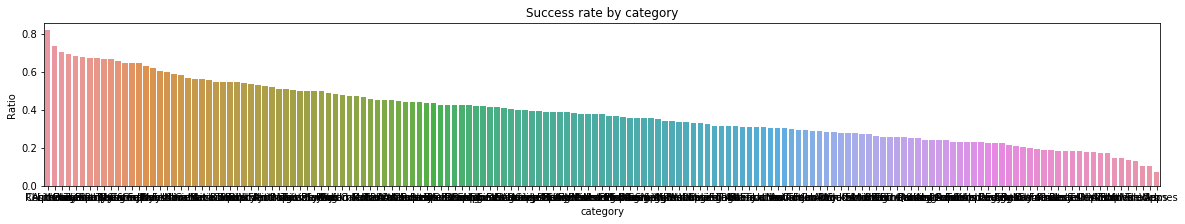

In [314]:
# ------------------------------------------------
# 2-6.カテゴリの影響度を確認
# ------------------------------------------------
show_state_count_plot("main_category",15,3, True)
show_successrate_barplot("main_category",15,3, True)

show_state_count_plot("category",20,3, True)
show_successrate_barplot("category",20,3, True)


▼country別の成功数と失敗数（降順）


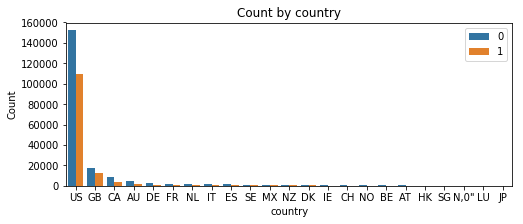


▼ country別の成功率（降順）


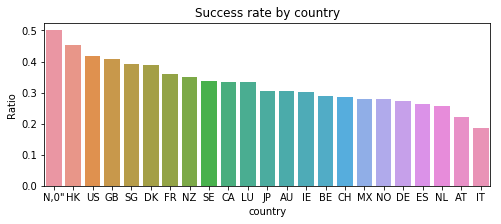

→N,0"について、件数が少ないが、成功率が高いので、悪影響にならないか不安

▼currency別の成功数と失敗数（降順）


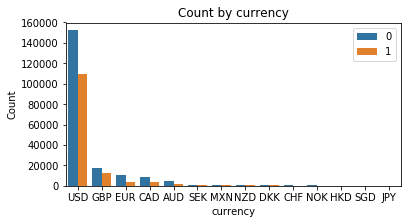


▼ currency別の成功率（降順）


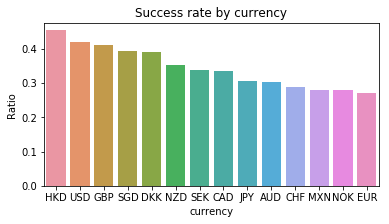

In [315]:
# ------------------------------------------------
# 2-7.countryの影響度を確認
# ------------------------------------------------
show_state_count_plot("country",8,3,True)
show_successrate_barplot("country",8,3,True)

print("→N,0\"について、件数が少ないが、成功率が高いので、悪影響にならないか不安")
#print("countryのN,0\"の件数")
#print(df["country"].where(df['country'] == 'N,0"').value_counts())
#df = df[(df['country'] != 'N,0"')]

# ------------------------------------------------
# 2-8.currencyの影響度を確認
# ------------------------------------------------
show_state_count_plot("currency",6,3,True)
show_successrate_barplot("currency",6,3,True)


▼ 相関係数をヒートマップにして可視化


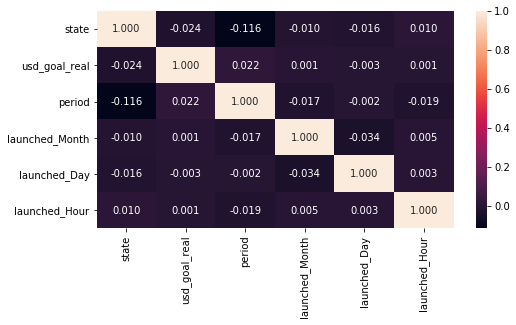

→stateとperiodの相関関係が他より高いことが分かる。


In [316]:
# ------------------------------------------------
# 2-9.相関係数をヒートマップにして可視化
# ------------------------------------------------
print("\n▼ 相関係数をヒートマップにして可視化")
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(), annot=True, fmt="1.3f")
plt.show()

print("→stateとperiodの相関関係が他より高いことが分かる。")

In [320]:
# ------------------------------------------------
# 2-2.ダミー変換
# ------------------------------------------------
# 抽出元の不要な項目を削除
df_drop = df.drop(['launched','deadline'], axis=1)

# one-hot-encoding
df_d = pd.get_dummies(df_drop, columns=['main_category','category',
                                 'country','currency',
                                 'launched_Month','launched_Day','launched_Hour','period'])

# ------------------------------------------------
# 2-6.データ標準化
# ------------------------------------------------
scaler = StandardScaler()
df_d['usd_goal_real'] = scaler.fit_transform(df_d.loc[:, ['usd_goal_real']])

print("\n▼ 先頭5行表示")
print(df_d.head(5))

#print("\n▼ 基本統計量")
#print(df_d.describe())


▼ 先頭5行表示
   state  usd_goal_real  main_category_Art  main_category_Comics  \
0      0      -0.036049                  0                     0   
1      0      -0.010379                  0                     0   
2      0       0.003147                  0                     0   
3      0      -0.032924                  0                     0   
5      1       0.007656                  0                     0   

   main_category_Crafts  main_category_Dance  main_category_Design  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
5                     0                    0                     0   

   main_category_Fashion  main_category_Film & Video  main_category_Food  ...  \
0                      0                           0                   0  ...  

In [321]:
# ****************************************************************************
# ◆ 3.モデル作成
# ****************************************************************************
X = df_d.drop('state', axis=1).values # 説明変数
y = df_d['state'].values              # 目的変数

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# リストへ変換
list_f = list(df.drop('state', axis=1).columns)
list_w = np.reshape(clf.coef_[0], -1).tolist()



▼ 回帰係数を表示（絶対値の降順：Top30）
                        feature     weight
0                 usd_goal_real -22.497091
1   category_Interactive Design  -4.815531
2                     period_80  -3.243800
3                     period_85   2.136534
4           category_Typography   1.968349
5          category_Residencies   1.874052
6                category_Video  -1.844406
7                  currency_CAD  -1.768139
8                    country_CA   1.629955
9              category_Hip-Hop  -1.558570
10                 category_Web  -1.468039
11               category_Dance   1.451492
12               category_Photo  -1.439146
13                category_Apps  -1.436105
14         category_Letterpress   1.426276
15        category_Mobile Games  -1.384117
16                    period_82  -1.368625
17    category_Camera Equipment   1.366742
18                   country_GB  -1.295260
19            category_Chiptune   1.291468
20                 currency_GBP   1.253694
21        category_Performanc

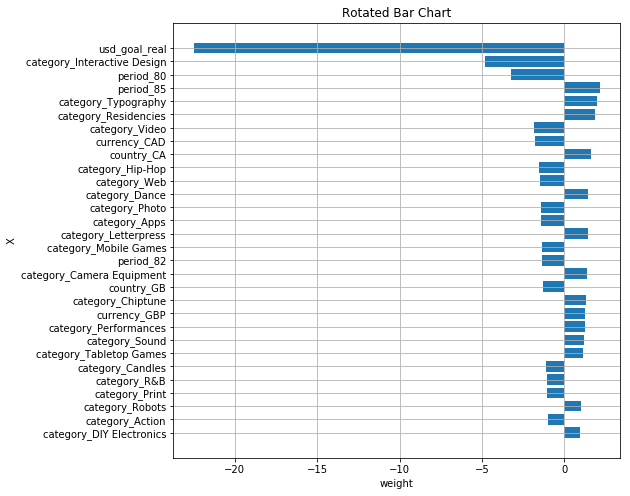

In [257]:
# ------------------------------------------------
# 3-1.重みを表示  
# ------------------------------------------------
print("\n▼ 回帰係数を表示（絶対値の降順：Top30）")
list_df = pd.DataFrame(columns=['feature','weight','abs_w'])
for i, feature in enumerate(list_f):
    #print(feature.ljust(30, ' ') + "---->   w{:.0f} = {:.3f}".format(i + 1, list_w[i]))
    list_df = list_df.append( pd.Series([feature,list_w[i],abs(list_w[i])],index=list_df.columns), ignore_index=True)

# 絶対値の降順ソートトップ30
list_df = list_df.sort_values('abs_w', ascending=False)
list_df.reset_index(drop=True,inplace=True)
list_df = list_df.drop('abs_w', axis=1)
list_head = list_df.head(30)
print(list_head)

# グラフで表示
plt.figure(figsize=(8, 8))
plt.barh(np.arange(len(list_head['feature']))[::-1], list_head['weight'], align='center')
plt.yticks(np.arange(len(list_head['feature']))[::-1], list_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('X')
plt.grid()
plt.show()

In [319]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************

# ラベルを予測
y_est = clf.predict(X)

print('\n▼ モデルの評価結果')

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])

conf_mat


▼ モデルの評価結果
対数尤度 = -11.013
正答率 = 68.113%
適合率（Precision※精度) = 70.213%
再現率（Recall※検出率) = 80.780%
F1値（F1-score） = 75.126%

▼ 混同行列


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,159717,38002
正解 = 資金調達成功,67759,66197


### わかったこと
- main_category等で件数が多い種類の重みの絶対値が大きくなる（影響度が高くなる）とは限らない。例）Film & Video
- main_category等で成功率が高い種類の重みの絶対値が大きくなる（影響度が高くなる）とは限らない。例）Dance
- periodの散布図で外れ値を確認することができる。(※今回、stateを成功と失敗で絞った時点で外れ値が消えた。）

### 気になること
- countryに含まれるN,0"について、そのまま利用して良かったのか。件数が少ないのに成功率が高いのが気になった。
- 数値項目でない項目ごとの相関関係をみる方法はあるか。例）main_categoryとcategory
- 重みのプラスとマイナスについて、それぞれに意味はあるのか。
- nameも説明変数にできるような方法はあるだろうか。
- あまり影響しているとは思えないような重みの絶対値が大きいのはなぜだろうか。例）period_80等
- 目標金額の外れ値が気になった。今回は、学習データをそのまま利用しているので、除外せずに利用した。